# Temperature unmixing with a sliding window

Spectral unmixing is the decomposition of a mixed spectrum into relative amounts of known endmembers. We can apply this idea to thermal imagery by thinking of a "temperature" as a spectrum of 1 wavelength. The "endmembers" are the average temperatures of different cover types in the mixed image. Since the endmembers change, unmixing will occur in a 3x3 sliding window. This gives a system of equations that we can solve for up to 9 cover types. Here, we will consider two classes: forest and "other".

### Example with synthetic data

In [1]:
import numpy as np
from numpy.lib.stride_tricks import sliding_window_view
from matplotlib import pyplot as plt

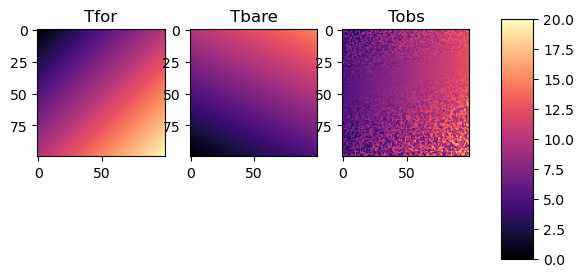

In [2]:
N = 100
IMG_SIZE = (N, N)

# % forest cover (hypothetically, can also just think of this as % cover
# by one of two classes.
cover = np.random.random(size=IMG_SIZE)
noise = np.random.random(size=IMG_SIZE)

# Both endmember temperatures vary across space and are spatially
# correlated.
x = np.arange(N) / 10

Tfor = np.add.outer(x, x)
Tbare = np.add.outer(10 - x, x / 2)

Tobs = Tfor * cover + Tbare * (1-cover) #+ noise

# Plot
f, ax = plt.subplots(1, 3)
im = []
titles = ["Tfor", "Tbare", "Tobs"]
for i, T in enumerate([Tfor, Tbare, Tobs]):
    im.append(ax[i].imshow(T, vmin=0, vmax=20, cmap="magma"))
    ax[i].set_title(titles[i])
  
f.subplots_adjust(right=0.8)
cbar_ax = f.add_axes([0.85, 0.15, 0.05, 0.5])
f.colorbar(im[0], cax=cbar_ax)


In [3]:
# We can only observe Tobs and cover. How well can we reconstruct the original endmembers?
WINDOW_SIZE = (3, 3)
data_cube   = np.stack([Tobs, cover], axis=-1)
views       = sliding_window_view(data_cube, WINDOW_SIZE, axis=(0, 1))
print(views.shape)

(98, 98, 2, 3, 3)


In [4]:
print(views[0, 0])

[[[5.15062381 9.36763794 6.63642842]
  [7.30572049 3.26617444 4.29796642]
  [2.91343262 7.96702467 6.32653389]]

 [[0.48493762 0.0685791  0.34985572]
  [0.2647224  0.68552057 0.58783851]
  [0.71735077 0.19717019 0.37615433]]]


In [5]:
# We can now derive a system of equations from each view and compute Tfor and Tbare by least squares
# The equation is: view[0, :, :] = Tfor * view[1, :, :] + Tbare * (1-view[1, :, :]) + eps
# where eps is just error.
view = views[0, 0]
lst = view[0, :, :].flatten()
cover_for = view[1, :, :].flatten()
cover_bare = 1 - cover_for
cover = np.stack((cover_for, cover_bare)).T
print(lst.shape)
print(cover.shape)

(9,)
(9, 2)


In [6]:
T, resid, rank, s = np.linalg.lstsq(cover, lst, rcond=None)

In [7]:
print(T)

[0.17914582 9.97802517]


In [8]:
# Compare with true value
print(Tfor[1, 1], Tbare[1, 1])

0.2 9.950000000000001


In [9]:
# Wrap up the above in a function so we can vectorize it
def solve_system(view):
    lst = view[0, :, :].flatten()
    cover = view[1, :, :].flatten()
    cover = np.stack((cover, 1-cover)).T
    
    x, resid, rank, s = np.linalg.lstsq(cover, lst, rcond=None)
    return x

solve_system(view)

array([0.17914582, 9.97802517])

In [10]:
views.shape

(98, 98, 2, 3, 3)

In [11]:
# Iterate over the first two axes
res = np.zeros(views.shape[:2] + (2,))
for i, j in np.ndindex(views.shape[:2]):
    res[i, j, ...] = solve_system(views[i, j, ...])

In [12]:
print(res.shape)

(98, 98, 2)


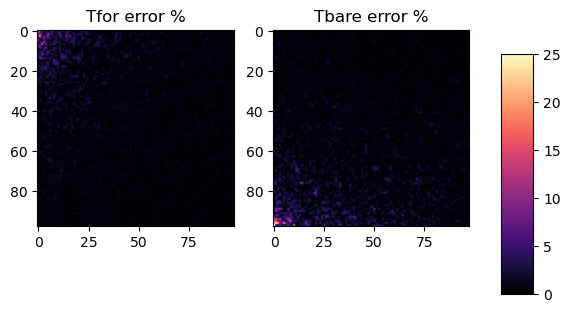

In [13]:
# Plot differences
def rel_difference(a, b):
    return np.abs(a - b) / b * 100

Tfor_error = rel_difference(res[..., 0], Tfor[1:99, 1:99])
Tbare_error = rel_difference(res[..., 1], Tbare[1:99, 1:99])
f, ax = plt.subplots(1, 2)
im = []
titles = ["Tfor error %", "Tbare error %"]
for i, T in enumerate([Tfor_error, Tbare_error]):
    im.append(ax[i].imshow(T, vmin=0, vmax=25, cmap="magma"))
    ax[i].set_title(titles[i])
  
f.subplots_adjust(right=0.8)
cbar_ax = f.add_axes([0.85, 0.15, 0.05, 0.5])
f.colorbar(im[0], cax=cbar_ax)
f.show()

### With real MODIS LST and ASLO forest cover data

In [39]:
import odc.stac
import odc.geo.geobox
import odc.geo.xr
import planetary_computer as pc
import pystac_client
import pystac
import pyproj
import stackstac
import rasterio

import numpy as np
import pandas as pd
import xarray as xr

import matplotlib

In [15]:
# Grab a MODIS image in a location with mixed forest

# LaPine, OR
lon, lat = -121.1403, 43.6479
date = "2020-08-01"

buffer = 0.25
bbox = [lon - buffer, lat - buffer, lon + buffer, lat + buffer]

# Load the PC catalog
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=pc.sign_inplace,
)

# We only need one MODIS image from this demo, so pull from a weekly median to ensure we minimize NAs
modis = catalog.search(
    collections=["modis-11A2-061"],
    bbox=bbox,
    datetime=date,
    query={"platform": {"eq": "aqua"}}
).get_all_items()[0]
modis

ID: MYD11A2.A2020209.h09v04.061.2021013151951
"Bounding Box: [-140.02161249, 40.00416667, -104.45078006, 49.99583333]"
created: 2021-01-13T15:19:51Z
updated: 2021-01-13T12:49:41.900000Z
datetime: None
platform: aqua
proj:epsg: None
"proj:wkt2: PROJCS[""unnamed"",GEOGCS[""Unknown datum based upon the custom spheroid"",DATUM[""Not specified (based on custom spheroid)"",SPHEROID[""Custom spheroid"",6371007.181,0]],PRIMEM[""Greenwich"",0],UNIT[""degree"",0.0174532925199433,AUTHORITY[""EPSG"",""9122""]]],PROJECTION[""Sinusoidal""],PARAMETER[""longitude_of_center"",0],PARAMETER[""false_easting"",0],PARAMETER[""false_northing"",0],UNIT[""Meter"",1],AXIS[""Easting"",EAST],AXIS[""Northing"",NORTH]]"
"proj:shape: [1200, 1200]"
instruments: ['modis']
end_datetime: 2020-08-03T23:59:59Z


In [16]:
forest = catalog.search(
    collections=["alos-fnf-mosaic"],
    datetime=date,
    bbox=bbox
).get_all_items()
forest

ID: N44W122_20_FNF
"Bounding Box: [-122.0, 43.0, -121.0, 44.0]"
Datetime: 2020-01-01 00:00:00+00:00
gsd: 25
title: N44W122_20_FNF
datetime: 2020-01-01T00:00:00Z
platform: ALOS-2
"proj:bbox: [-122.0, 43.0, -121.0, 44.0]"
proj:epsg: 4326
"proj:shape: [4500, 4500]"
description: Forest/Non-Forest Classification


We need to get the forest classification in the MODIS projection. This can do proportion forest cover for us with `rasterio.enums.Resampling.mean`. But, we first have to pull the data and make an `is_dense` variable for when `C == 0`.

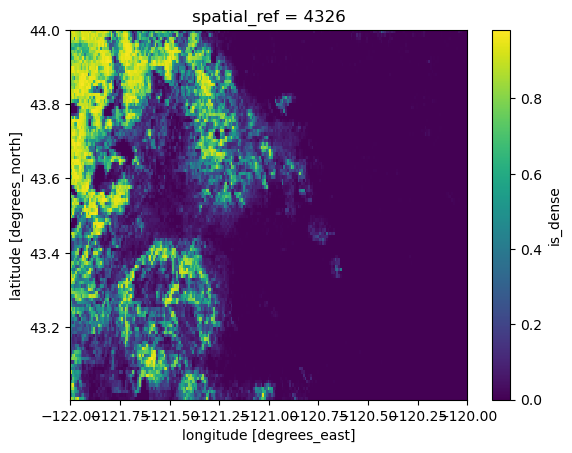

In [28]:
forest_data = odc.stac.load(
    forest,
    bands="C",
    chunks = {}
).reduce(np.nanmean, dim="time") # drop time axis

forest_data["is_dense"] = forest_data["C"] == 1
# Discard original class
forest_data = forest_data.drop("C")
# Coarsen to 1km - native is 25m, so 25m/px x 40px = 1km
forest_1km = forest_data.coarsen(dict(latitude=40, longitude=40), boundary="trim").mean()
forest_1km["is_dense"].plot.imshow()

Now load in the MODIS image, using the coarsened forest density as a template.

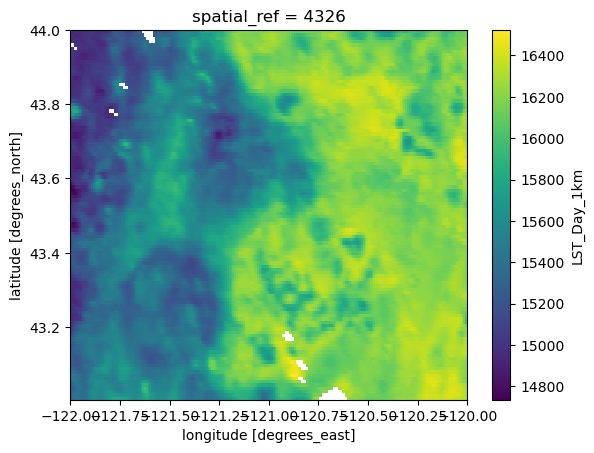

In [40]:
modis_data = odc.stac.load(
    [modis],
    bands=["QC_Day", "LST_Day_1km"],
    chunks={},
    geobox=forest_1km.odc.geobox,
    resampling=dict(
        QC_Day="max", # take the "worst" QC flags
        LST_Day_1km="bilinear"
    )
).reduce(np.nanmean, dim="time")
modis_qc_ok = modis_data.where(modis_data["QC_Day"] == 0)
modis_qc_ok["LST_Day_1km"].plot.imshow()

Merge the data together

In [41]:
modis_forest = xr.merge(
    [modis_qc_ok, forest_1km]
)
modis_forest

<xarray.Dataset>
Dimensions:      (latitude: 148, longitude: 360)
Coordinates:
  * latitude     (latitude) float64 43.01 43.02 43.03 43.04 ... 43.98 43.99 44.0
  * longitude    (longitude) float64 -122.0 -122.0 -122.0 ... -120.0 -120.0
    spatial_ref  int32 4326
Data variables:
    QC_Day       (latitude, longitude) float64 dask.array<chunksize=(148, 360), meta=np.ndarray>
    LST_Day_1km  (latitude, longitude) float64 dask.array<chunksize=(148, 360), meta=np.ndarray>
    is_dense     (latitude, longitude) float64 dask.array<chunksize=(148, 360), meta=np.ndarray>